Trabalho sobre análise exploratória de dados utilizando Python, Linguagem SQL e Banco de Dados SQLite. 
Os dados utilizados nesse projeto são dados reais, disponíveis a partir do IMDB.

Realizando a instalação e carregamento dos pacotes a serem utilizados

In [1]:
# Instalando o pacote
%pip install -q imdb-sqlite

Note: you may need to restart the kernel to use updated packages.


In [2]:
# instalando o pacote pycountry (nomes dos paises, etc...)
%pip install -q pycountry

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importando pacotes para realização das análises numéricas

import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

Carregamento dos Dados utilizados

In [4]:
# Data size: 10.6 GB !!!!
%%time
!imdb-sqlite

UsageError: Line magic function `%%time` not found.


In [5]:
# abrindo conexão ao banco de dados
conn = sqlite3.connect("imdb.db")

In [6]:
# Realizando a extração das listas de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

In [7]:
# type(tabelas)
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [8]:
# Convertendo o dataframe em uma lista
tabelas = tabelas["Table_Name"].values.tolist()

In [9]:
# Verificando o esquema de cada tabela
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




Primeira parte - Quais as categorias de filmes mais comuns no IMDB ?

In [10]:
# Criando a primeira consulta 
consulta1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'''

In [11]:
resultado1 = pd.read_sql_query(consulta1, conn)

In [12]:
# Total com base na categoria
display(resultado1)

,type,COUNT
0,movie,616096
1,short,880024
2,tvEpisode,6838517
3,tvMiniSeries,44349
4,tvMovie,136818
5,tvPilot,2
6,tvSeries,228411
7,tvShort,10617
8,tvSpecial,37654
9,video,263049


In [13]:
# Além de calcular o percentual, é necessário criar uma coluna nova
resultado1['percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum()) * 100

In [14]:
display(resultado1)

,type,COUNT,percentual
0,movie,616096,6.779833
1,short,880024,9.684231
2,tvEpisode,6838517,75.254515
3,tvMiniSeries,44349,0.488039
4,tvMovie,136818,1.505615
5,tvPilot,2,0.000022
6,tvSeries,228411,2.513551
7,tvShort,10617,0.116835
8,tvSpecial,37654,0.414364
9,video,263049,2.894725


In [15]:
# Filtrando apenas 4 categorias. 3 categorias com mais títulos e 1 categorias com o restante
others = {}

others['COUNT'] = resultado1[resultado1['percentual'] < 5]['COUNT'].sum()

others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()

others['type'] = 'others'

In [16]:
others

{'COUNT': 752548, 'percentual': 8.28142048390123, 'type': 'others'}

In [17]:
resultado1 = resultado1[resultado1['percentual'] > 5]

In [18]:
resultado1 = resultado1.append(others, ignore_index=True)

In [19]:
resultado1 = resultado1.sort_values(by = 'COUNT', ascending=False)

In [20]:
resultado1.head()

,type,COUNT,percentual
2,tvEpisode,6838517,75.254515
1,short,880024,9.684231
3,others,752548,8.281420
0,movie,616096,6.779833


In [21]:
# List comprehension, para ajustar o label a ser construido no gráfico de rosca
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i],2)) +'%'+']' for i in resultado1.index]

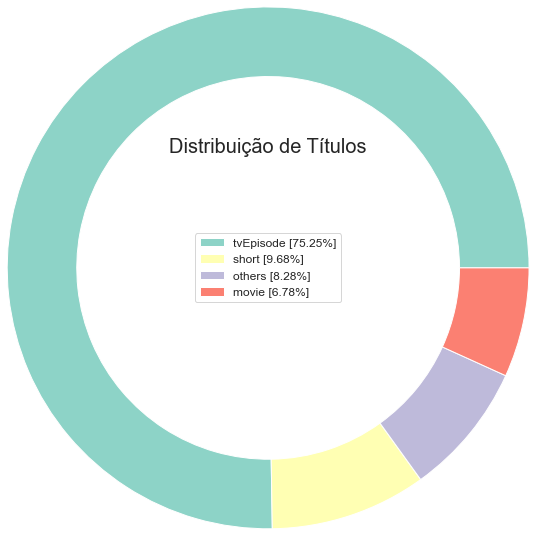

In [22]:
#Plot

cs = cm.Set3(np.arange(100))

f = plt.figure()

plt.pie(resultado1['COUNT'], labeldistance=1, radius=3, colors=cs, wedgeprops= dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict={'fontsize': 20, 'fontweight': 20})
plt.show()

Segunda Parte - Qual o número de títulos por gêneros ???

In [23]:
consulta2 = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres'''

In [24]:
resultado2 = pd.read_sql_query(consulta2, conn)

In [25]:
display(resultado2)

,genres,COUNT(*)
0,Action,14127
1,"Action,Adult",11
2,"Action,Adult,Adventure",2
3,"Action,Adult,Comedy",6
4,"Action,Adult,Crime",10
...,...,...
1463,"Thriller,Western",43
1464,War,1306
1465,"War,Western",14
1466,Western,5107


In [26]:
# O '\N' acima pode indicar que temos filmes que não possuem um genero definido
resultado2['genres'] = resultado2['genres'].str.lower().values

In [27]:
temp = resultado2['genres'].dropna()

In [28]:
# Neste ponto foi apresentado o conceito do one-hot encoded
padrao = '(?u)\\b[\\w-]+\\b'
vetor = CountVectorizer(token_pattern= padrao, analyzer='word').fit(temp)

In [29]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [30]:
bag_generos = vetor.transform(temp)

In [31]:
type(bag_generos)

scipy.sparse.csr.csr_matrix

In [32]:
generos_unicos = vetor.get_feature_names()

In [33]:
generos = pd.DataFrame(bag_generos.todense(), columns=generos_unicos, index=temp.index)

In [34]:
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1468 entries, 0 to 1467
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1468 non-null   int64
 1   adult        1468 non-null   int64
 2   adventure    1468 non-null   int64
 3   animation    1468 non-null   int64
 4   biography    1468 non-null   int64
 5   comedy       1468 non-null   int64
 6   crime        1468 non-null   int64
 7   documentary  1468 non-null   int64
 8   drama        1468 non-null   int64
 9   family       1468 non-null   int64
 10  fantasy      1468 non-null   int64
 11  film-noir    1468 non-null   int64
 12  game-show    1468 non-null   int64
 13  history      1468 non-null   int64
 14  horror       1468 non-null   int64
 15  music        1468 non-null   int64
 16  musical      1468 non-null   int64
 17  mystery      1468 non-null   int64
 18  n            1468 non-null   int64
 19  news         1468 non-null   int64
 20  reality-

In [35]:
generos = generos.drop(columns = 'n', axis=0)

In [36]:
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending=False) / generos.shape[0]

In [37]:
generos_percentual.head(10)

drama          17.915531
comedy         16.961853
documentary    15.803815
adventure      14.918256
action         14.509537
romance        13.283379
crime          13.010899
mystery        12.397820
thriller       12.261580
horror         12.193460
dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

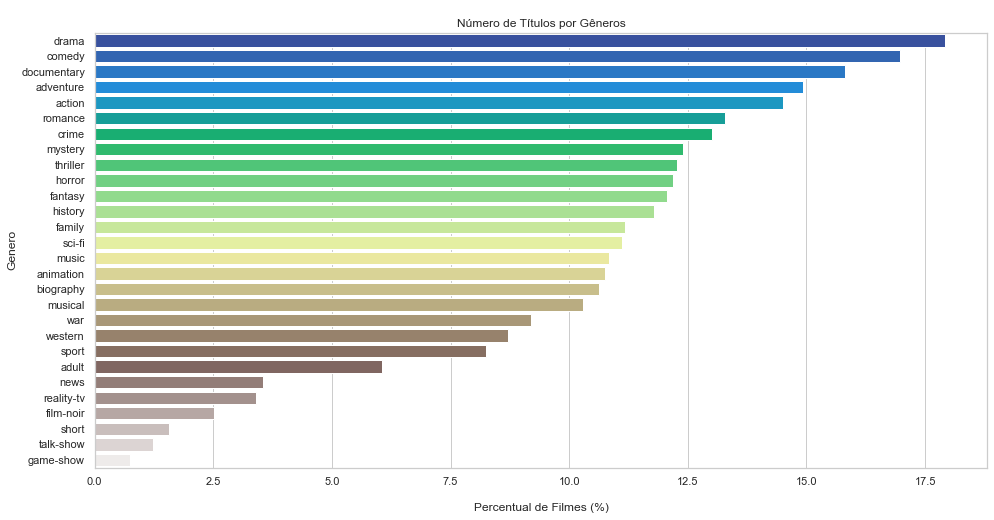

In [38]:
plt.figure(figsize = (16,8))
sns.barplot(x=generos_percentual.values, y=generos_percentual.index, orient="h", palette="terrain")
plt.ylabel('Genero')
plt.xlabel("\nPercentual de Filmes (%)")
plt.title("\nNúmero de Títulos por Gêneros")
plt.show

Terceira parte - Mediana de avaliação dos filmes por gênero

In [41]:
consulta3 = '''SELECT rating, genres FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE premiered <= 2022 AND type = 'movie' '''

In [42]:
resultado3 = pd.read_sql_query(consulta3, conn)

In [43]:
display(resultado3)

,rating,genres
0,5.3,Romance
1,4.5,\N
2,6.0,"Action,Adventure,Biography"
3,4.7,Drama
4,4.5,Drama
...,...,...
278133,5.8,Thriller
278134,6.4,"Drama,History"
278135,3.8,"Adventure,History,War"
278136,8.3,Drama


In [44]:
# Diferente do passo anterior, nessa situação foi criada uma função para separar os diferentes generos.
def return_genres(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    padrao = '(?u)\\b[\\w-]+\\b'
    vetor = CountVectorizer(token_pattern= padrao, analyzer='word').fit(temp)
    generos_unicos = vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [45]:
generos_unicos = return_genres(resultado3)

In [46]:
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [96]:
generos_count = []
generos_ratings = []

In [97]:
for item in generos_unicos:

    # contagem de filmes por generos
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    # print(resultado.values[0][0])
    generos_count.append(resultado.values[0][0])

    #  # Avaliação de filmes por generos
    # consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    # resultado = pd.read_sql_query(consulta, conn)
    # generos_ratings.append(np.median(resultado['rating']))

In [98]:
for item in generos_unicos:

    #  contagem de filmes por generos
    # consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    # resultado = pd.read_sql_query(consulta, conn)
    # print(resultado.values[0][0])
    # generos_count.append(resultado.values[0][0])

    # Avaliação de filmes por generos
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    generos_ratings.append(np.median(resultado['rating']))

In [99]:
df_generos_ratings = pd.DataFrame()
df_generos_ratings['genres'] = generos_unicos
df_generos_ratings['count'] = generos_count
df_generos_ratings['rating'] = generos_ratings

In [102]:
df_generos_ratings.head(20)

,genres,count,rating
0,action,28769,5.80
1,adult,4392,5.80
2,adventure,17393,6.00
3,animation,4739,6.50
4,biography,8470,7.00
5,comedy,68560,6.00
6,crime,23725,6.10
7,documentary,41900,7.30
8,drama,123039,6.30
9,family,10719,6.30


In [103]:
df_generos_ratings = df_generos_ratings.drop(index = 18)

In [108]:
from sympy import false


df_generos_ratings = df_generos_ratings.sort_values(by = 'rating', ascending = False)

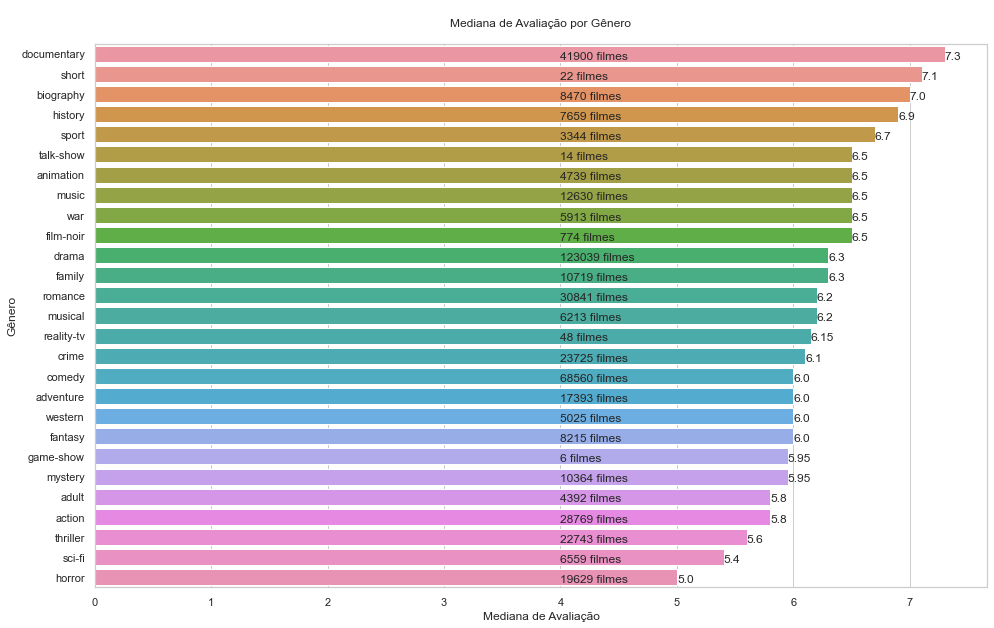

In [111]:
plt.figure(figsize = (16,10))

sns.barplot(y = df_generos_ratings.genres, x = df_generos_ratings.rating, orient = "h")

for i in range(len(df_generos_ratings.index)):
    plt.text(4.0,
             i + 0.25,
             str(df_generos_ratings['count'][df_generos_ratings.index[i]]) + " filmes")

    plt.text(df_generos_ratings.rating[df_generos_ratings.index[i]],
            i + 0.25,
            round(df_generos_ratings["rating"][df_generos_ratings.index[i]],2))

plt.ylabel('Gênero')
plt.xlabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação por Gênero\n')
plt.show()